In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

device = "cpu"

OSError: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory

In [23]:
# load the Cora dataset
dataset = 'Cora'
path = osp.join('../', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

# Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

# Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


# GAE for link prediction

[code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py)


In [24]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list

In [25]:
def get_link_logits(model, x , edge_index , neg_edge_index) :
    z = model.encode(x , edge_index) #encode
    link_logits = model.decode(z, edge_index, neg_edge_index) # decode
    return link_logits
    
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [26]:
neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

print(data.train_pos_edge_index.shape) # torch.Size([2, 8976])
print(neg_edge_index.shape) # torch.Size([2, 8976])
link_logits = get_link_logits(model , data.x , data.train_pos_edge_index,neg_edge_index)
print(link_logits.size()) # torch.Size([17952])

link_logits.sigmoid()
# tensor([0.5464, 0.5480, 0.5567,  ..., 0.5421, 0.5441, 0.5430], grad_fn=<SigmoidBackward0>)

torch.Size([2, 8976])
torch.Size([2, 8976])
torch.Size([17952])


tensor([0.5294, 0.5346, 0.5323,  ..., 0.5382, 0.5381, 0.5442],
       grad_fn=<SigmoidBackward0>)

In [27]:
def train():
    model.train()
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    link_logits = get_link_logits(model , data.x , data.train_pos_edge_index,neg_edge_index)
    optimizer.zero_grad()
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss
train()

tensor(0.6819, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [28]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        
        link_logits = get_link_logits(model , data.x , pos_edge_index,neg_edge_index)
        
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


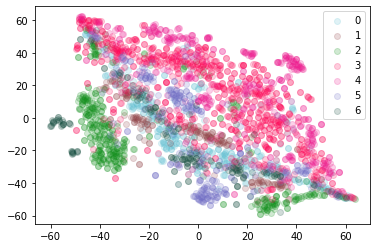

In [29]:
dataset = Planetoid(path, "Cora", transform=T.NormalizeFeatures())
z = model.encode(dataset.data.x,dataset.data.edge_index) #encode

emb = TSNE(n_components=2, learning_rate='auto').fit_transform(z.detach().numpy())
labels = dataset.data.y.detach().numpy()
fig, ax = plt.subplots()

number_of_colors = len(np.unique(labels))

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
for idx , i in enumerate(np.unique(labels)) :
    emb_ = emb[np.where(labels == i ),:].squeeze()
    ax.scatter(x=emb_[:,0],y=emb_[:,1],c=color[idx], label=i,alpha=0.2)
else :
    ax.legend()
    plt.show()